# Below is how I approach the Movie project
### 1. Frame the Problem and Look at the Big Picture
1. Define the objective in business terms.
    - There are two objectives namely:
        1. Knowing the projected revenue.
        2. Determinig customer interests.
2. How will your solution be used?
    - By companies trying to understand their profits.
    - Movie lovers can get recommendation of movies.
3. What are the current solutions/workarounds (if any)?
    - Can get data from TMDB and Rotten tomatoes (currently use kaggle data).
    - For data analysis and machine learning assume no solutions.
4. How should you frame this problem (supervised/unsupervised,online/offline, etc.)?
    - Supervised and batch learning.
        NB: online learning might be possible. Will experiment at end of project.
5. How should performance be measured?
    - For revenue predictions RSME will be used.
    - For recommender system F1-score will be used.
        NB: For both models will experiment other performance measures. 
6. Is the performance measure aligned with the business objective?
    - For current business needs yes.
    - However, if this is a real world scenario I believe not.
7. What would be the minimum performance needed to reach the business objective?
    - For revenue a score of 94% is acceptable. 
    - For recommender system generating high recall score is preferable. 
8. What are comparable problems? Can you reuse experience or tools?
    - Assume none exist.
9. Is human expertise available?
    - Assume no.
10. How would you solve the problem manually?
    - For revenue talking to people in movie industry.
    - For recommendor asking random people.
11. List the assumptions you (or others) have made so far.
    - None identified at this point. 
12. Verify assumptions if possible.
    - None to verify. 

In [1]:
# Deleted all the previous code due to data.
# However, decided on using the same data for now.
# Fetching my own data a bit hard and will deviate me from main goal.
# Below is the python package should I want to use my own data.
# https://github.com/celiao/tmdbsimple/blob/master/tmdbsimple/movies.py

In [3]:
# EDA libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# setting column view maximum.
pd.set_option("display.max_colwidth", None)

In [7]:
# load data.
movies = pd.read_csv("../../../Data/archive/movies_metadata.csv", low_memory=False)

In [8]:
# seperate data into train and test.
# this is to avoid data snooping.

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(movies, test_size=0.2, random_state=44)

In [11]:
movies = train_set

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36372 entries, 9522 to 14100
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  36372 non-null  object 
 1   belongs_to_collection  3626 non-null   object 
 2   budget                 36372 non-null  object 
 3   genres                 36372 non-null  object 
 4   homepage               6245 non-null   object 
 5   id                     36372 non-null  object 
 6   imdb_id                36358 non-null  object 
 7   original_language      36362 non-null  object 
 8   original_title         36372 non-null  object 
 9   overview               35594 non-null  object 
 10  popularity             36367 non-null  object 
 11  poster_path            36069 non-null  object 
 12  production_companies   36369 non-null  object 
 13  production_countries   36369 non-null  object 
 14  release_date           36297 non-null  object 
 15  reve

In [15]:
# column features by data type.
# these relevant columns have less nulls.

relevant_cols = ["adult", "budget", "genres", 
                 "original_language", "popularity", "production_companies", 
                 "production_countries", "release_date", "video", 
                 "runtime", "spoken_languages", "status", 
                 "vote_average", "vote_count", "revenue"]

numeric_cols = ["budget", "popularity", "runtime",
                "vote_average", "vote_count", "revenue"]

categorical_cols = ["adult", "genres", "original_language",
                    "production_companies", "production_countries",
                    "spoken_languages", "status", "video"]

date_cols = ["release_date"]


In [17]:
movies = movies[relevant_cols]

In [19]:
movies.describe()

,runtime,vote_average,vote_count,revenue
count,36156.000000,36366.000000,36366.000000,3.636600e+04
mean,94.190452,5.618737,109.285926,1.115906e+07
std,37.946414,1.922103,485.863405,6.413562e+07
min,0.000000,0.000000,0.000000,0.000000e+00
25%,85.000000,5.000000,3.000000,0.000000e+00
50%,95.000000,6.000000,10.000000,0.000000e+00
75%,107.000000,6.800000,34.000000,0.000000e+00
max,1256.000000,10.000000,14075.000000,2.787965e+09


In [21]:
movies.describe(include='object')

,adult,budget,genres,original_language,popularity,production_companies,production_countries,release_date,video,spoken_languages,status
count,36372,36372,36372,36362,36367,36369,36369,36297,36366,36366,36301
unique,5,1073,3531,88,35120,18600,2052,15478,2,1636,6
top,False,0,"[{'id': 18, 'name': 'Drama'}]",en,0.0,[],"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2007-01-01,False,"[{'iso_639_1': 'en', 'name': 'English'}]",Released
freq,36363,29286,3986,25806,55,9470,14223,102,36297,17920,35998


In [23]:
# first, I want to remove some corrupt numeric columns.

# this function identifies corrupt keys.
# keys are corrupt if value of numeric columns isn't numeric.
# also if revenue has null value I interpret that as corrupt. 

def corruptIndex():
    
    set_ = set()
    arr = []
    
    # this checks each columns value if it's convetible to floating point.
    # if not, the instance is identified as corrupt.
    for col in numeric_cols:
        for key, val in movies[col].items():
            try:
                float(val)
            except:
                if key not in set_:
                    set_.add(key)
                    arr.append(key)
                    
    for key, val in movies['revenue'].items():
        if (pd.isnull(val)) and (key not in set_):
            set_.add(key)
            arr.append(key)
            
    return np.array(arr)

In [25]:
corrupt_indexes = corruptIndex()

In [27]:
movies = movies.drop(corrupt_indexes, axis=0)

In [29]:
# corrupt values are those that are numeric.
# different from above function in that the instance isn't corrupt.
# in the above function, majority of instance was corrupted.
# for this function, only this feature appears to be corrupt.

def corruptOriginalLanguage():
    for key, val in movies['original_language'].items():
        try:
            if type(float(val)) == float:
                movies.loc[key, 'original_language'] = None
        except:
            pass

In [31]:
corruptOriginalLanguage()

In [33]:
# this function extracts ids from specific columns.
# these ids are then sorted to create new features. 

def idExtraction(column):
    
    movies[f'{column}_edit'] = pd.Series()
    arr = []
    num = ''
    
    for key, val in movies[column].items():
        for char in val:
            try:
                if type(int(char)) == int:
                    num += char
            except:
                if len(num) > 0:
                    arr.append(int(num))
                    num = ''
        new_value = ''
        
        arr.sort()
        
        if len(arr) >= 2:
            new_value = str(arr[0]) + str(np.sum(arr[1:-1])) + str(arr[-1])
        elif len(arr) > 0:
            new_value = str(arr[0])
        else:
            new_value = arr
            
        if len(new_value) == 0:
            movies.loc[key, f'{column}_edit'] = 0
        else:
            movies.loc[key, f'{column}_edit'] = new_value
        arr = []

In [35]:
idExtraction('genres')

In [36]:
idExtraction('production_companies')

In [37]:
movies.head(10)

,adult,budget,genres,original_language,popularity,production_companies,production_countries,release_date,video,runtime,spoken_languages,status,vote_average,vote_count,revenue,genres_edit,production_companies_edit
9522,False,30000000,"[{'id': 18, 'name': 'Drama'}]",en,14.471373,"[{'name': 'Lakeshore Entertainment', 'id': 126}, {'name': 'Malpaso Productions', 'id': 171}, {'name': 'Epsilon Motion Pictures', 'id': 1171}, {'name': 'Warner Bros.', 'id': 6194}, {'name': 'Albert S. Ruddy Productions', 'id': 16311}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2004-12-15,False,132.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ga', 'name': 'Gaeilge'}]",Released,7.7,2519.0,216763646.0,18,126753616311
18639,False,0,"[{'id': 35, 'name': 'Comedy'}]",fr,3.653474,"[{'name': 'France 2 Cinéma', 'id': 83}, {'name': 'SND', 'id': 2902}, {'name': 'Canal+', 'id': 5358}, {'name': 'Vendôme Production', 'id': 23291}]","[{'iso_3166_1': 'FR', 'name': 'France'}]",2010-12-20,False,106.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'iso_639_1': 'es', 'name': 'Español'}]",Released,6.6,90.0,0.0,35,2834323291
41633,False,0,"[{'id': 10402, 'name': 'Music'}]",en,1e-06,[],"[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1972-09-10,False,55.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.6,5.0,0.0,10402,0
18473,False,750000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]",en,8.560726,"[{'name': 'Glass Eye Pix', 'id': 1360}, {'name': 'Dark Sky Films', 'id': 4592}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2011-12-01,False,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.4,223.0,78396.0,270.053,13600.04592
17713,False,0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]",en,5.38902,"[{'name': 'Heyday Films', 'id': 7364}, {'name': 'British Broadcasting Corporation (BBC)', 'id': 15278}, {'name': 'Carnival Films & Television', 'id': 31807}, {'name': 'Masterpiece', 'id': 33473}, {'name': 'Runaway Fridge TV', 'id': 46340}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2011-08-28,False,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.8,63.0,0.0,18539648,73648055846340
35397,False,0,[],ja,0.917899,"[{'name': 'Asmik Ace Entertainment', 'id': 3033}]","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2003-12-13,False,116.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,6.2,10.0,0.0,0,3033
5960,False,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]",sr,1.980535,"[{'name': 'Centar Film', 'id': 15165}]","[{'iso_3166_1': 'RS', 'name': 'Serbia'}]",1982-01-01,False,92.0,"[{'iso_639_1': 'sr', 'name': 'Srpski'}]",Released,7.8,16.0,0.0,180.035,15165
3856,False,80000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]",en,8.534176,"[{'name': 'Village Roadshow Pictures', 'id': 79}, {'name': 'NPV Entertainment', 'id': 172}, {'name': 'Warner Bros.', 'id': 6194}, {'name': 'The Canton Company', 'id': 22351}, {'name': 'Mars Production Pty. Ltd.', 'id': 53997}]","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]",2000-11-10,False,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.4,271.0,33463969.0,2853878,792871753997
44835,False,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'name': 'Foreign'}]",mr,0.356645,[],"[{'iso_3166_1': 'IN', 'name': 'India'}]",2004-12-10,False,107.0,"[{'iso_639_1': 'mr', 'name': ''}]",Released,8.0,2.0,0.0,180.010769,0
43162,False,0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, 'name': 'Adventure'}, {'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]",en,0.144113,"[{'name': 'Toei Animation', 'id': 5542}]","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",1980-04-25,False,0.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,7.5,4.0,0.0,1244878,5542


In [38]:
# names are retrieved using the below function.
# seperators are used to spilt the data for easy retrival of ids.

def extractNames(first_seperator, second_seperator, feature_name):
    
    dictionary = {}
    string = ''
    
    for key, val in movies[feature_name].items():
        li = val.split(first_seperator)
        for i in range(1, len(li)):
            name = li[i].split(second_seperator)[0]
            if name not in dictionary:
                dictionary[name] = 1
            else:
                dictionary[name] += 1
        string =''
        
    arr = []
    for key, val in dictionary.items():
        arr.append([val, key])
        
    return sorted(arr, key=lambda a: a, reverse=True)

In [39]:
genres_count_arr = extractNames("'name':", "}", "genres")

In [40]:
production_companies_count_arr = extractNames("'name':", ", 'id'", "production_companies")

In [41]:
# similar to above function.
# seperator and technique for retriving the language and country defer.

def extractLanguageCountry(seperator, feature_name):
    
    string = ''
    dictionary = {}
    
    for key, val in movies[feature_name].items():
        li = val.split(seperator)
        for i in range(1, len(li)):
            name = li[i].split(",")[0]
            if name not in dictionary:
                dictionary[name] = 1
            else:
                dictionary[name] += 1
        string ='' 
    arr = []
    for key, val in dictionary.items():
        arr.append([val, key])
    return sorted(arr, key=lambda a: a, reverse=True)

In [43]:
production_countries_count_arr = extractLanguageCountry("'iso_3166_1':", "production_countries")

In [44]:
spoken_languages_count_arr = extractLanguageCountry("'iso_639_1':", "spoken_languages")

In [45]:
# these are the newly added features.

new_cols = ['genres_edit','production_companies_edit']
relevant_cols = relevant_cols + new_cols

In [46]:
# numeric cols are replaced with mean.
# other cols are replaced with most frequent item.

from sklearn.impute import SimpleImputer
def dealWithNulls(data):
    
    for num in numeric_cols:

        null_series = pd.isnull(data[num])
        null_count = null_series.value_counts()

        if len(null_count) > 1:
            computed_mean = np.mean(data[num])
            data[num].fillna(computed_mean, inplace=True)
            
    imputer = SimpleImputer(strategy="most_frequent")
    new_df = imputer.fit_transform(data)
    movies = pd.DataFrame(new_df, columns = relevant_cols)
    return movies

In [47]:
movies = dealWithNulls(movies)

In [51]:
movies.drop(["genres", "production_companies", "production_countries", "spoken_languages"],
            inplace=True,
            axis=1)

In [61]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36366 entries, 0 to 36365
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   adult                      36366 non-null  object
 1   budget                     36366 non-null  object
 2   original_language          36356 non-null  object
 3   popularity                 36366 non-null  object
 4   release_date               36366 non-null  object
 5   video                      36366 non-null  object
 6   runtime                    36366 non-null  object
 7   status                     36366 non-null  object
 8   vote_average               36366 non-null  object
 9   vote_count                 36366 non-null  object
 10  revenue                    36366 non-null  object
 11  genres_edit                36366 non-null  object
 12  production_companies_edit  36366 non-null  object
dtypes: object(13)
memory usage: 3.6+ MB


In [63]:
 movies = movies.astype({
                    'adult':bool,
                    'budget': float,
                    'original_language': str,
                    'popularity': float,
                    'release_date': 'datetime64[ns]',
                    'revenue': float,
                    'runtime': float,
                    'status': str,
                    'video': bool,
                    'vote_average': float,
                    'vote_count': int,
                    'genres_edit': float,
                    'production_companies_edit': float

                })

In [65]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36366 entries, 0 to 36365
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   adult                      36366 non-null  bool          
 1   budget                     36366 non-null  float64       
 2   original_language          36366 non-null  object        
 3   popularity                 36366 non-null  float64       
 4   release_date               36366 non-null  datetime64[ns]
 5   video                      36366 non-null  bool          
 6   runtime                    36366 non-null  float64       
 7   status                     36366 non-null  object        
 8   vote_average               36366 non-null  float64       
 9   vote_count                 36366 non-null  int32         
 10  revenue                    36366 non-null  float64       
 11  genres_edit                36366 non-null  float64       
 12  prod

In [67]:
movies.describe()

,budget,popularity,release_date,runtime,vote_average,vote_count,revenue,genres_edit,production_companies_edit
count,3.636600e+04,36366.000000,36366,36366.000000,36366.000000,36366.000000,3.636600e+04,3.636600e+04,3.636600e+04
mean,4.236573e+06,2.911808,1992-05-20 02:17:05.177363456,94.190452,5.618737,109.285926,1.115906e+07,5.060795e+10,1.696239e+13
min,0.000000e+00,0.000000,1874-12-09 00:00:00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.387347,1978-11-06 12:00:00,85.000000,5.000000,3.000000,0.000000e+00,3.500000e+01,0.000000e+00
50%,0.000000e+00,1.129338,2001-08-24 00:00:00,95.000000,6.000000,10.000000,0.000000e+00,1.800360e+02,6.194000e+03
75%,0.000000e+00,3.723764,2010-11-06 00:00:00,107.000000,6.800000,34.000000,0.000000e+00,1.853800e+05,9.195001e+04
max,3.800000e+08,294.337037,2020-12-16 00:00:00,1256.000000,10.000000,14075.000000,2.787965e+09,1.074911e+14,8.914537e+15
std,1.769181e+07,5.480693,NaN,37.836689,1.922103,485.863405,6.413562e+07,2.102345e+12,2.035837e+14


In [69]:
attributes = ["budget", "popularity", "runtime", "vote_average", "vote_count", "revenue"]
corr_matrix = movies[attributes].corr()
corr_matrix["revenue"].sort_values(ascending=False)

revenue         1.000000
vote_count      0.807902
budget          0.776249
popularity      0.524684
runtime         0.105924
vote_average    0.082572
Name: revenue, dtype: float64

In [71]:
# plots of various kinds

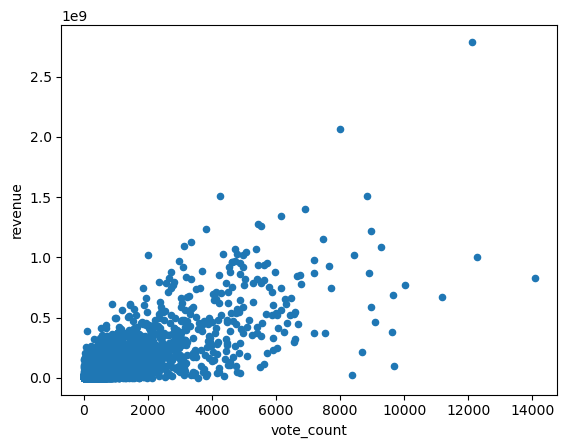

In [73]:
movies.plot(kind="scatter", x="vote_count", y="revenue")
plt.show()

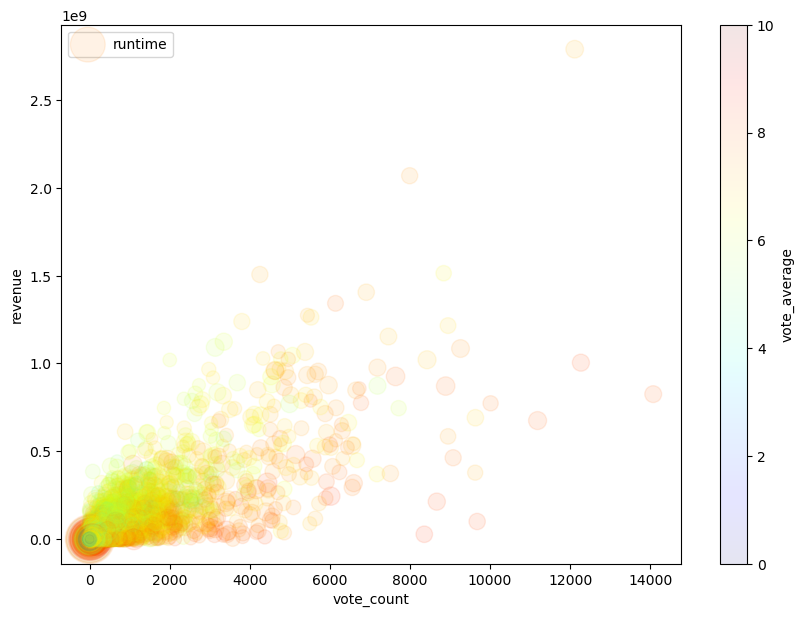

In [74]:
movies.plot(kind="scatter", x="vote_count", y="revenue", alpha=0.1,
           s="runtime", label="runtime", figsize=(10,7),
           c="vote_average", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

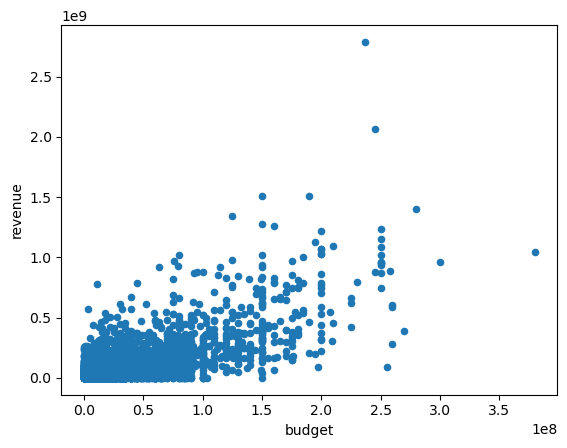

In [76]:
movies.plot(kind="scatter", x="budget", y="revenue")
plt.show()

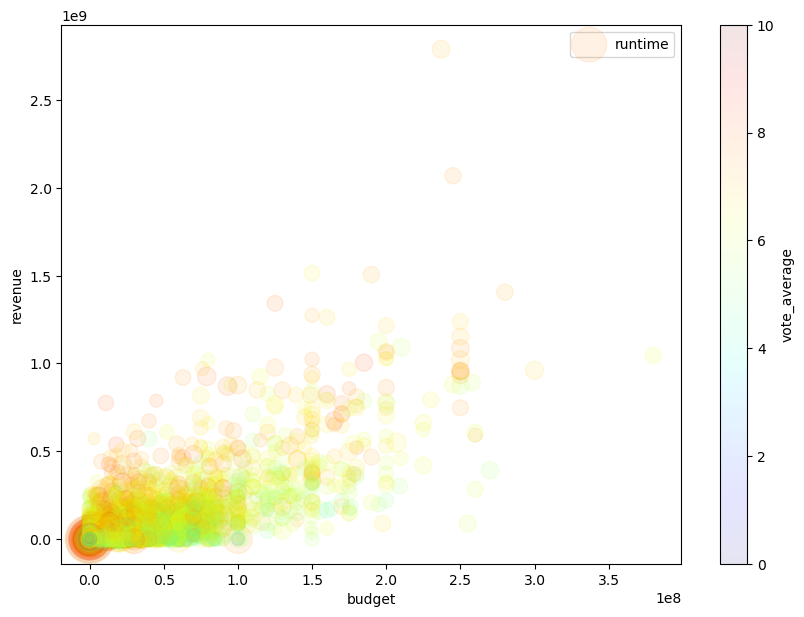

In [77]:
movies.plot(kind="scatter", x="budget", y="revenue", alpha=0.1,
           s="runtime", label="runtime", figsize=(10,7),
           c="vote_average", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

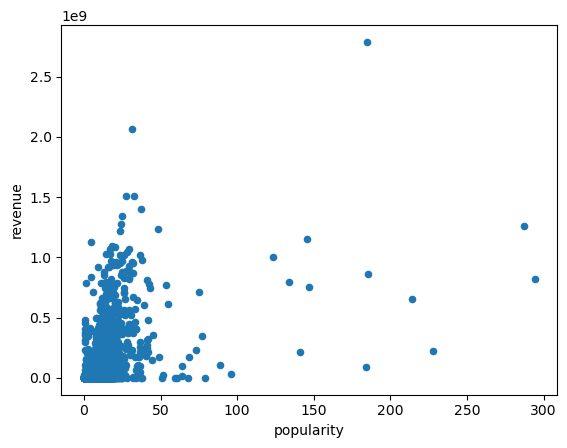

In [78]:
movies.plot(kind="scatter", x="popularity", y="revenue")
plt.show()

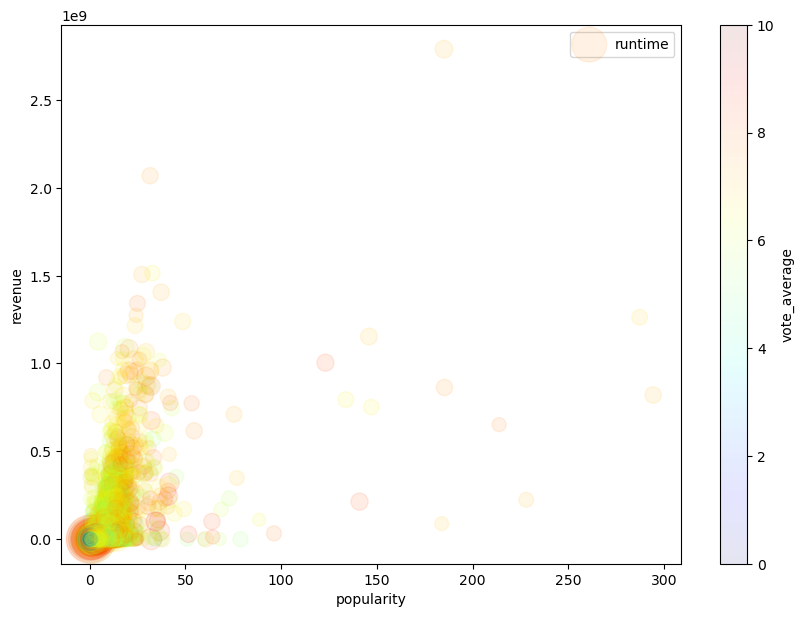

In [81]:
movies.plot(kind="scatter", x="popularity", y="revenue", alpha=0.1,
           s="runtime", label="runtime", figsize=(10,7),
           c="vote_average", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()

In [85]:
from pandas.plotting import scatter_matrix

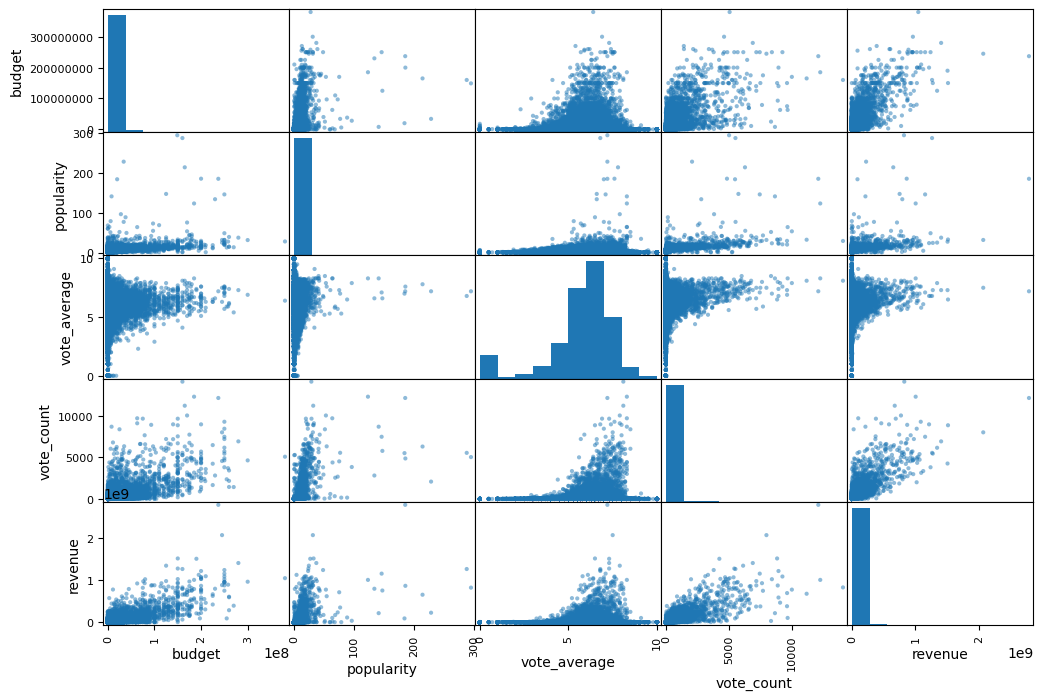

In [87]:
num_attributes = ['budget','popularity','vote_average', 'vote_count','revenue']
scatter_matrix(movies[num_attributes], figsize=(12,8), diagonal='hist')
plt.show()

In [88]:
genres_count_arr = np.array(genres_count_arr)
production_companies_count_arr = np.array(production_companies_count_arr)
production_countries_count_arr = np.array(production_countries_count_arr)
spoken_languages_count_arr = np.array(spoken_languages_count_arr)

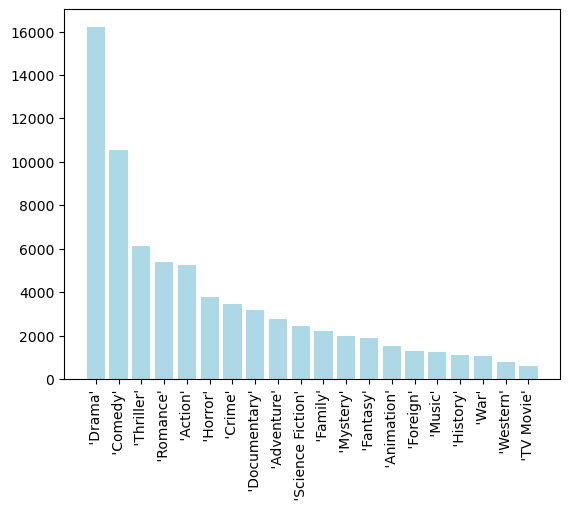

In [89]:
# shows the genres count in the dataset.

X = genres_count_arr[:,1]
Y = genres_count_arr[:,0].astype(np.int64)
fig, ax = plt.subplots()
ax.bar(X, Y, color="lightblue")
ax.tick_params(axis="x", rotation=90)
plt.show()


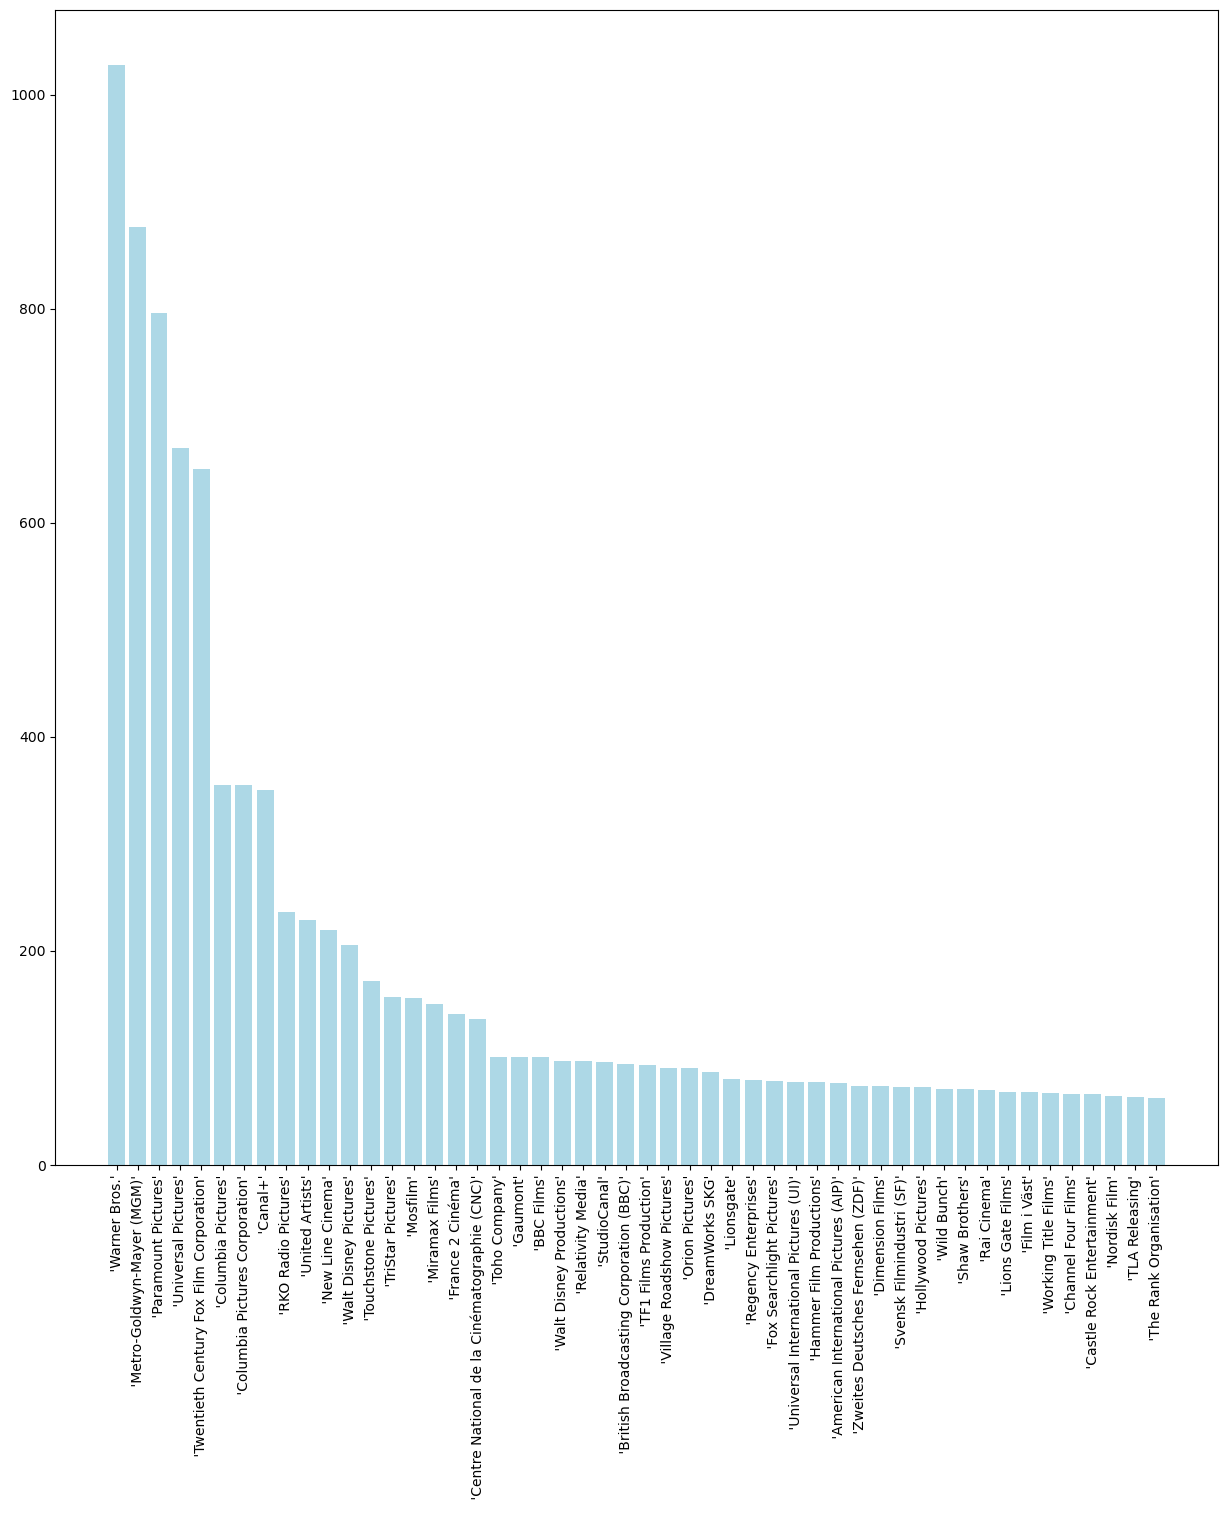

In [90]:
# top 50 production companies.

X = production_companies_count_arr[:50,1]
Y = production_companies_count_arr[:50,0].astype(np.int64)
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.bar(X, Y, color="lightblue")
ax.tick_params(axis="x", rotation=90)
plt.show()

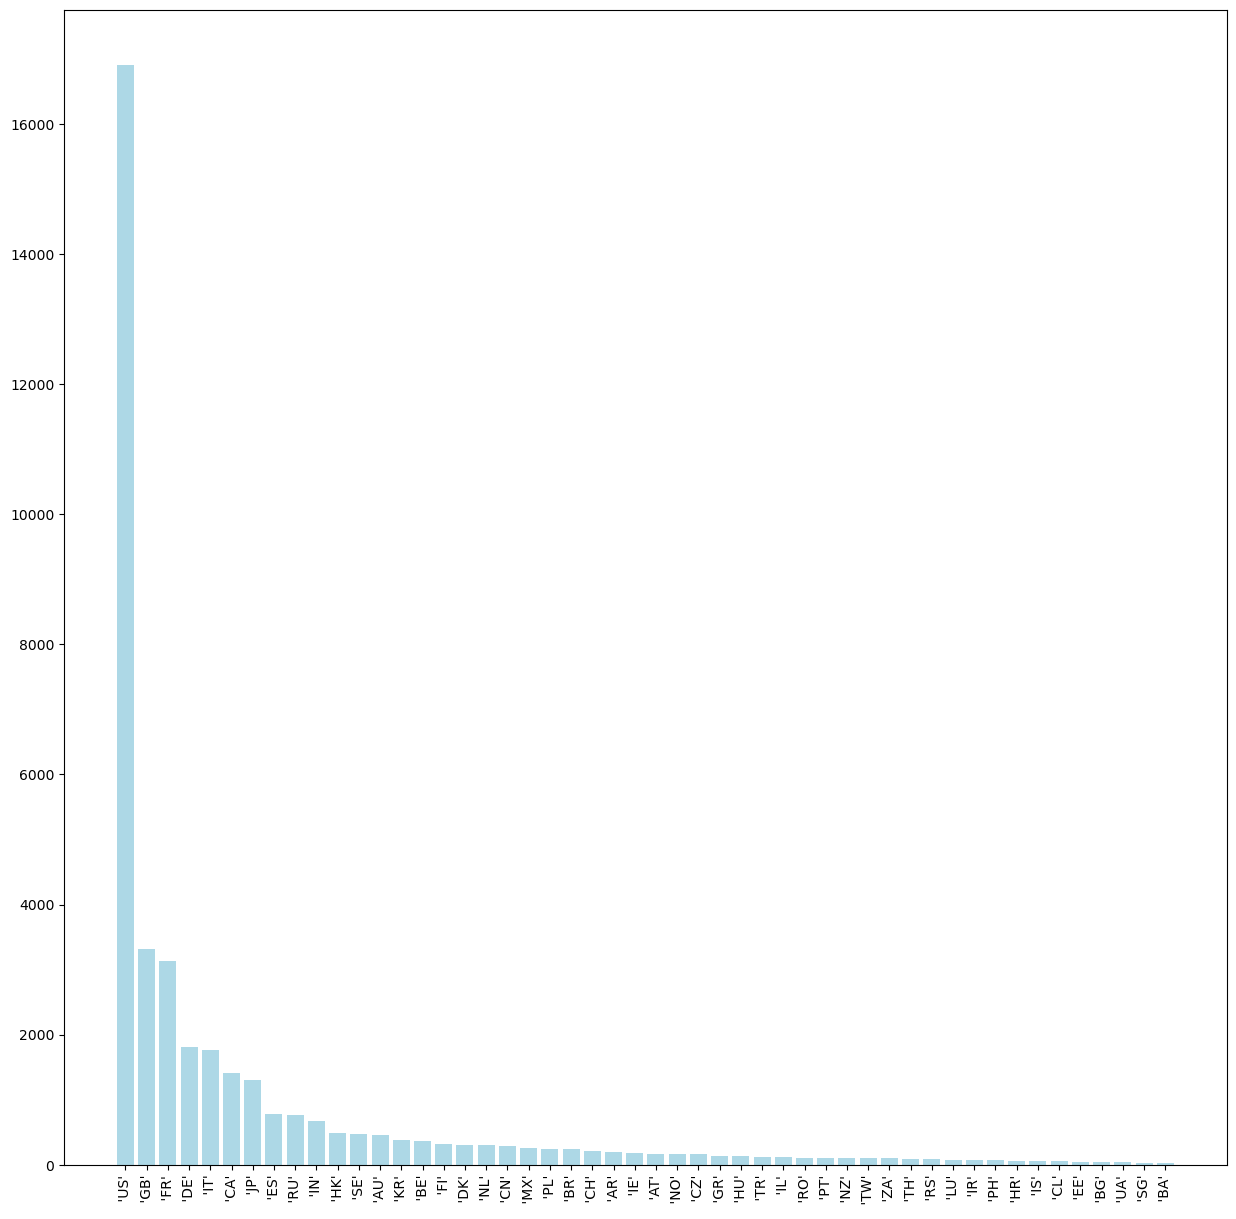

In [94]:
# top 50 production countries.

X = production_countries_count_arr[:50,1]
Y = production_countries_count_arr[:50,0].astype(np.int64)
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.bar(X, Y, color="lightblue")
ax.tick_params(axis="x", rotation=90)
plt.show()

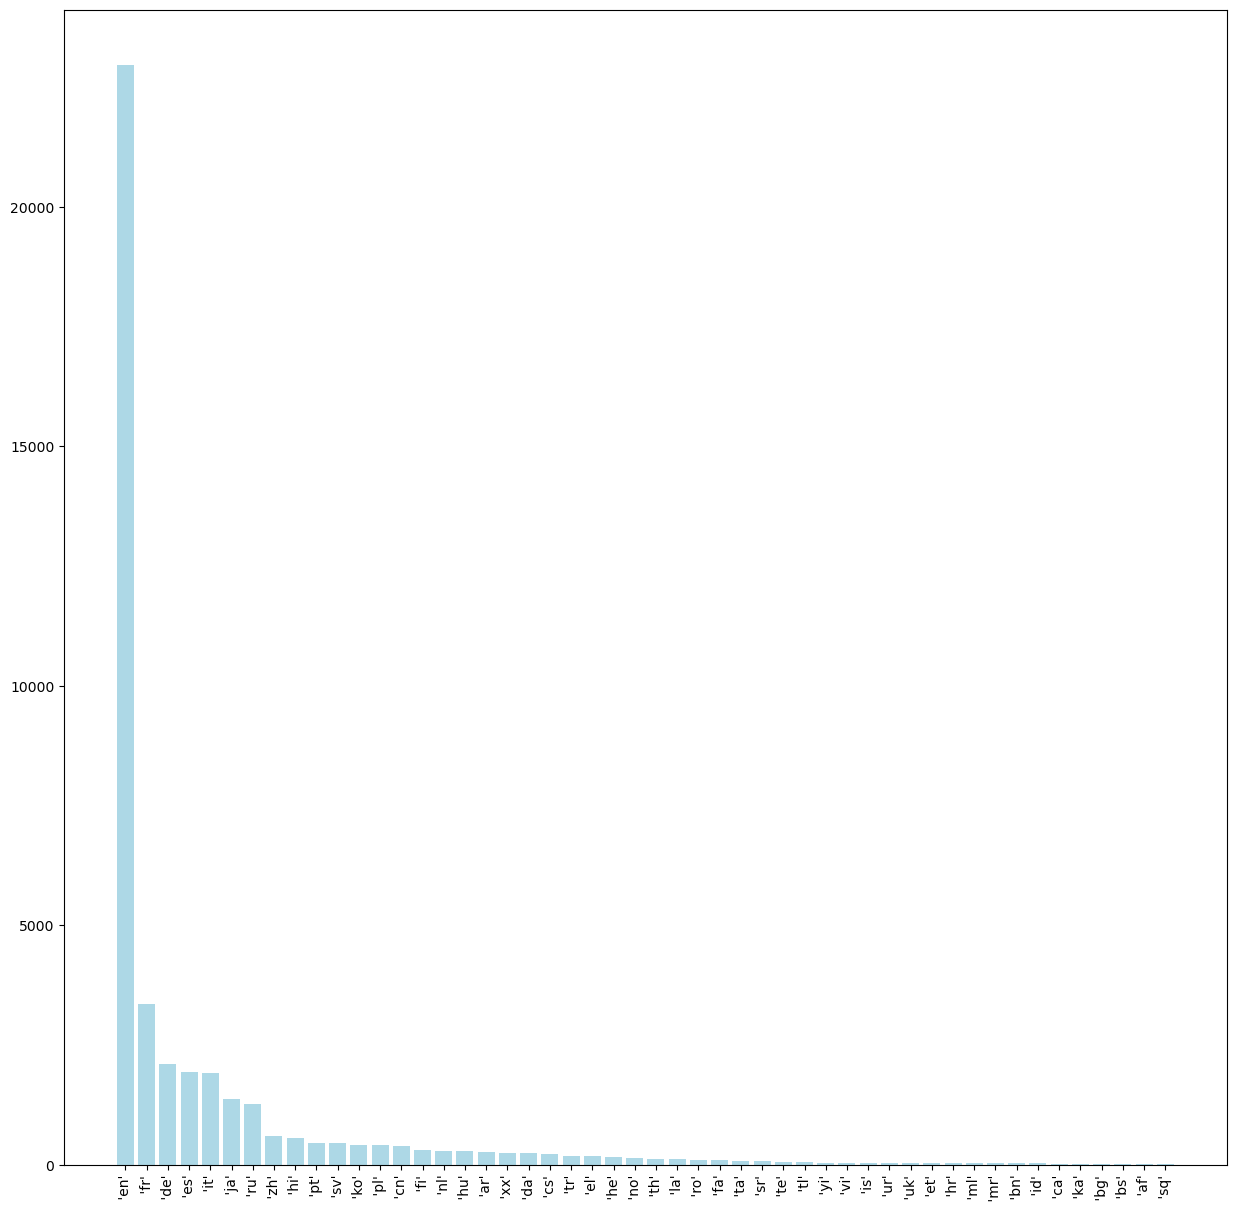

In [97]:
# top 50 spoken languages.

X = spoken_languages_count_arr[:50,1]
Y = spoken_languages_count_arr[:50,0].astype(np.int64)
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
ax.bar(X, Y, color="lightblue")
ax.tick_params(axis="x", rotation=90)
plt.show()

In [107]:
date_popularity = movies[['release_date', 'revenue']].groupby('release_date').agg('sum')

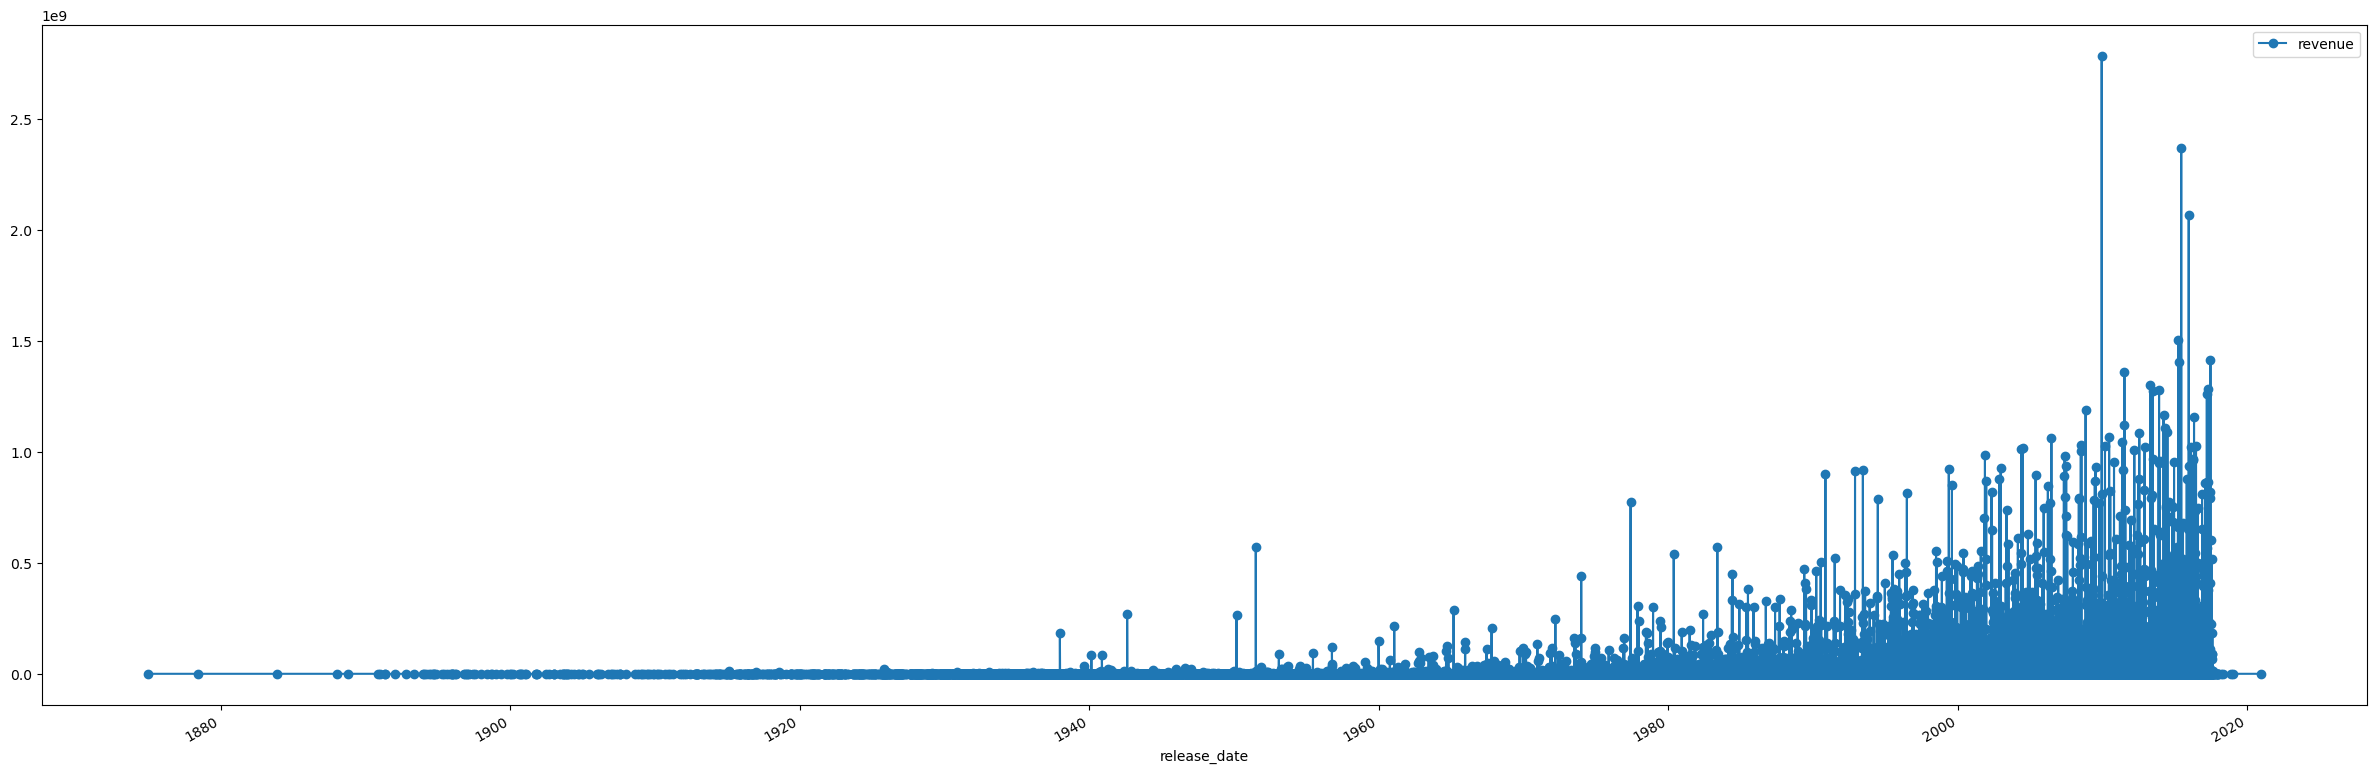

In [109]:
date_popularity.plot(kind='line',marker='o',figsize=(30,10))
plt.show()

In [131]:
budget_revenue = movies[['budget','revenue']].groupby('revenue').agg('sum')

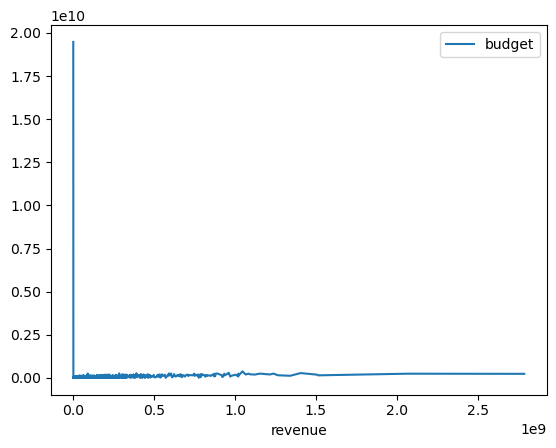

In [140]:
budget_revenue.plot(kind='line')
plt.show()

In [125]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36366 entries, 0 to 36365
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   adult                      36366 non-null  bool          
 1   budget                     36366 non-null  float64       
 2   original_language          36366 non-null  object        
 3   popularity                 36366 non-null  float64       
 4   release_date               36366 non-null  datetime64[ns]
 5   video                      36366 non-null  bool          
 6   runtime                    36366 non-null  float64       
 7   status                     36366 non-null  object        
 8   vote_average               36366 non-null  float64       
 9   vote_count                 36366 non-null  int32         
 10  revenue                    36366 non-null  float64       
 11  genres_edit                36366 non-null  float64       
 12  prod

In [127]:
new_categorical_cols = ["adult", "original_language", "status", 
                        "video"]
numeric_minus_label_cols = ["budget", "popularity", "runtime",
                            "vote_average", "vote_count", "genres_edit", 
                            "production_companies_edit"]
labels_col = "revenue"

In [73]:
# creating dummy variables
from sklearn.preprocessing import OneHotEncoder
one_encoder = OneHotEncoder()
movies_cat_one_encoder = one_encoder.fit_transform(movies[new_categorical_cols])

In [75]:
movies_cat_one_encoder = movies_cat_one_encoder.toarray()

In [76]:
# standardization of numerical features
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
standardized_num_attributes = standardizer.fit_transform(movies[numeric_minus_label_cols])
standardized_num_attributes

array([[ 1.45625503,  2.10917174,  0.99929641, ...,  4.95972156,
        -0.06800539, -0.23858593],
       [-0.23946859,  0.1353252 ,  0.31212324, ..., -0.03969468,
        -0.06800536, -0.25287322],
       [-0.23946859, -0.53129177, -1.03579336, ..., -0.21464337,
        -0.06798708, -0.25316398],
       ...,
       [-0.23946859, -0.35158284, -0.05789308, ..., -0.21875981,
        -0.00590952, -0.25316301],
       [-0.23946859,  0.61323516,  0.15354481, ..., -0.19817761,
        -0.06797301, -0.25316397],
       [-0.23946859,  0.41927492, -0.37504993, ..., -0.19406117,
        -0.06797327, -0.25316398]])

In [77]:
movies_features = np.concatenate((movies_cat_one_encoder, standardized_num_attributes), axis=1)
movies_features.shape

(36366, 102)

In [78]:
movies_label = movies.loc[:,labels_col]

In [91]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=False)
movies_features_poly = poly_features.fit_transform(movies_features)

In [93]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(movies_features_poly, movies_label)

MemoryError: Unable to allocate 50.8 GiB for an array with shape (36366, 187459) and data type float64

In [ ]:
from sklearn.metrics import mean_squared_error
movies_prediction = lin_reg.predict(movies_features_poly)
lin_mse = mean_squared_error(movies_label, movies_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, 
                             movies_features_poly, 
                             movies_label,
                             scoring="neg_mean_squared_error", 
                             cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

In [140]:
lin_reg.intercept_, lin_reg.coef_

(4.140762509796225e+17,
 array([ 1.42274385e+13, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11804441e+17,
        -2.11804441e+17, -2.11804441e+17, -2.11804441e+17, -2.11

In [83]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=0.001, penalty=None, eta0=0.1)
sgd_reg.fit(movies_features, movies_label)

SGDRegressor(eta0=0.1, penalty=None)

In [132]:
movies_prediction = sgd_reg.predict(movies_features)
sgd_mse = mean_squared_error(movies_label, movies_prediction)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

66056276.61135425

In [134]:
sgd_scores = cross_val_score(sgd_reg, 
                             movies_features, 
                             movies_label,
                             scoring="neg_mean_squared_error", 
                             cv=10)
sgd_rmse_scores = np.sqrt(-sgd_scores)

In [136]:
display_scores(sgd_rmse_scores)

Scores: [2.37818508e+08 6.04408361e+07 4.77206766e+07 3.19177061e+07
 4.57409740e+07 3.91525685e+07 3.90869961e+07 4.17239719e+07
 3.46915327e+07 3.60821625e+07]
Mean: 61437593.20376895
Standard deviation: 59296062.130920164


In [138]:
sgd_reg.intercept_, sgd_reg.coef_

(array([-555640.51754737]),
 array([-5.55640518e+05,  5.03720501e+07, -4.90054410e+07,  8.18246730e+07,
         6.79243057e+07,  1.35468651e+07,  5.28692729e+07,  1.30132017e+07,
         6.35838176e+07, -3.35568397e+07,  2.95514086e+07, -1.28351672e+08,
         4.49741969e+07,  5.06677036e+07,  9.65621330e+07,  4.29250359e+07,
         4.37953970e+07,  4.68571877e+07,  4.03693562e+07,  5.65891739e+05,
         4.24489823e+07,  2.27562278e+05, -2.52913887e+07,  4.97948958e+07,
         4.63187179e+07,  4.06580522e+07, -3.61578517e+07, -1.68827685e+07,
         5.29660726e+07,  4.74836878e+07,  1.26361800e+07,  4.84790048e+07,
        -1.20361664e+08,  1.23626768e+08, -1.32607496e+07,  4.32512681e+07,
         1.89590107e+08,  4.19459478e+07, -2.78467174e+07,  7.79976509e+07,
         6.07277056e+06,  3.87012284e+07,  4.68415424e+07, -6.59004298e+07,
        -1.46515075e+08, -3.64209661e+08, -6.22724631e+07, -6.13715803e+07,
        -7.86122562e+08,  2.64465613e+07, -8.82582103e+08,  

In [65]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(movies_features, movies_label)

DecisionTreeRegressor()

In [66]:
movies_predictions = tree_reg.predict(movies_features)
tree_mse = mean_squared_error(movies_label, movies_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [67]:
scores = cross_val_score(tree_reg, 
                         movies_features, 
                         movies_label,
                         scoring="neg_mean_squared_error", 
                         cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [68]:
display_scores(tree_rmse_scores)

Scores: [37114348.24530567 47563471.08239463 39278877.30879684 38702046.97454102
 34111977.86424411 44687906.77090346 42122886.55777298 38243550.26017458
 42544542.27709221 35004273.3549781 ]
Mean: 39937388.069620356
Standard deviation: 4041875.7528977687


In [69]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(movies_features, movies_label)

RandomForestRegressor()

In [70]:
movies_predictions = forest_reg.predict(movies_features)
forest_mse = mean_squared_error(movies_label, movies_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

11221327.381502982

In [145]:
scores = cross_val_score(forest_reg, 
                         movies_features, 
                         movies_label,
                         scoring="neg_mean_squared_error", 
                         cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [146]:
display_scores(forest_rmse_scores)

Scores: [34174905.83729578 33499441.04372202 24346216.90262174 27466769.15538815
 22762767.52881909 29689916.91839155 29356663.99260699 31055068.24509437
 30528093.01486147 25033621.06133888]
Mean: 28791346.370014004
Standard deviation: 3638606.186366348
